# Example of using gen to create a surface memory experiment circuit

# Step 1: import gen

In [1]:
# HACK: manually get `gen` into the PATH.
# Assumes this notebook is being run from a server in the gen directory.
import os
import sys
import pathlib
assert os.getcwd().endswith('gen')
gen_path = str(pathlib.Path(os.getcwd()).parent.absolute())
if gen_path not in sys.path:
    sys.path.append(gen_path)

In [2]:
import gen
import stim

In [3]:
print(f'{gen.__version__=}')
print(f'{stim.__version__=}')

gen.__version__='0.1.0'
stim.__version__='1.15.dev1745883134'


# Step 2: define the layout used by the surface code

In [4]:
def make_surface_code(diameter: int) -> gen.StabilizerCode:
    tiles = []

    for x in range(-1, diameter):
        for y in range(-1, diameter):
            m = x + 1j * y + 0.5 + 0.5j
            potential_data = [m + 1j**k * (0.5 + 0.5j) for k in range(4)]
            data = [d for d in potential_data if 0 <= d.real < diameter if 0 <= d.imag < diameter]
            if len(data) not in [2, 4]:
                continue

            basis = "XZ"[(x.real + y.real) % 2 == 0]
            if not (0 <= m.real < diameter - 1) and basis != "Z":
                continue
            if not (0 <= m.imag < diameter - 1) and basis != "X":
                continue
            tiles.append(gen.Tile(measure_qubit=m, data_qubits=data, bases=basis))

    patch = gen.Patch(tiles)
    obs_x = gen.PauliMap({q: "X" for q in patch.data_set if q.real == 0}, name='LX')
    obs_z = gen.PauliMap({q: "Z" for q in patch.data_set if q.imag == 0}, name='LZ')
    return gen.StabilizerCode(patch, logicals=[(obs_x, obs_z)])

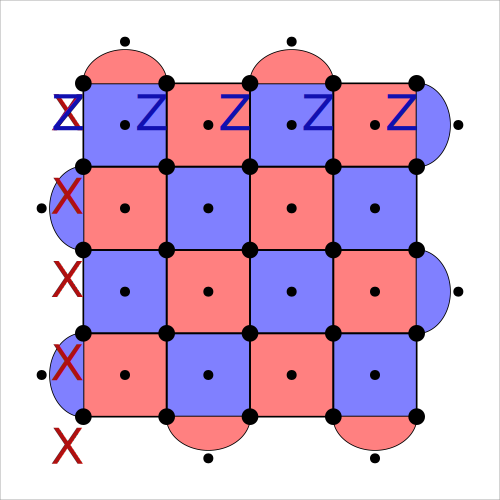

In [5]:
# Test and show

make_surface_code(4).verify()
make_surface_code(5).verify()

make_surface_code(5).to_svg(show_measure_qubits=True, show_coords=False)

# Step 3: define idle chunk and init chunk

In [6]:
def make_surface_code_idle_chunk(code: gen.StabilizerCode) -> gen.Chunk:
    builder = gen.ChunkBuilder(allowed_qubits=code.used_set)

    # Find X and Z basis measurement qubits.
    mxs = {tile.measure_qubit for tile in code.patch if tile.basis == "X"}
    mzs = {tile.measure_qubit for tile in code.patch if tile.basis == "Z"}

    # Reset measure qubits into their respective bases.
    builder.append("RX", mxs)
    builder.append("RZ", mzs)
    builder.append("TICK")

    # Generate the two qubit gate layers.
    x_offsets = [0.5 + 0.5j, -0.5 + 0.5j, 0.5 - 0.5j, -0.5 - 0.5j]
    z_offsets = [0.5 + 0.5j, 0.5 - 0.5j, -0.5 + 0.5j, -0.5 - 0.5j]
    for layer in range(4):
        cxs: list[tuple[int, int]] = []
        for tile in code.tiles:
            offsets = x_offsets if tile.basis == 'X' else z_offsets
            offset = offsets[layer]
            m = tile.measure_qubit
            d = m + offset
            if d in code.data_set:
                order = -1 if tile.basis == "Z" else +1
                cxs.append((m, d)[::order])
        builder.append("CX", cxs)
        builder.append("TICK")

    # Measure the measure qubits in their respective bases.
    builder.append("MX", mxs)
    builder.append("MZ", mzs)

    # Annotate the expected flows implemented by the circuit.
    for tile in code.tiles:
        builder.add_flow(start=tile, ms=[tile.measure_qubit])
        builder.add_flow(end=tile, ms=[tile.measure_qubit])
    for obs in code.flat_logicals:
        builder.add_flow(start=obs, end=obs)

    return builder.finish_chunk()

In [7]:
# Test and show

make_surface_code_idle_chunk(make_surface_code(4)).verify()
make_surface_code_idle_chunk(make_surface_code(5)).verify()

make_surface_code_idle_chunk(make_surface_code(5)).to_html_viewer()

'\n<!DOCTYPE html>\n<html>\n<head>\n  <meta charset="UTF-8" />\n</head>\n<body>\n    <div id="circuit-viewer-container" tabindex=0>\n        <div id="step">Loading...</div>\n        <button id="btnPrev">Previous Layer (hotkey: q)</button>\n        <button id="btnNext">Next Layer (hotkey: e)</button>\n        <a id="crumble-link" href="https://algassert.com/crumble#circuit=Q%280,0%29_0;Q%280,1%29_1;Q%280,2%29_2;Q%280,3%29_3;Q%280,4%29_4;Q%281,0%29_5;Q%281,1%29_6;Q%281,2%29_7;Q%281,3%29_8;Q%281,4%29_9;Q%282,0%29_10;Q%282,1%29_11;Q%282,2%29_12;Q%282,3%29_13;Q%282,4%29_14;Q%283,0%29_15;Q%283,1%29_16;Q%283,2%29_17;Q%283,3%29_18;Q%283,4%29_19;Q%284,0%29_20;Q%284,1%29_21;Q%284,2%29_22;Q%284,3%29_23;Q%284,4%29_24;Q%28-0.5,1.5%29_25;Q%28-0.5,3.5%29_26;Q%280.5,-0.5%29_27;Q%280.5,0.5%29_28;Q%280.5,1.5%29_29;Q%280.5,2.5%29_30;Q%280.5,3.5%29_31;Q%281.5,0.5%29_32;Q%281.5,1.5%29_33;Q%281.5,2.5%29_34;Q%281.5,3.5%29_35;Q%281.5,4.5%29_36;Q%282.5,-0.5%29_37;Q%282.5,0.5%29_38;Q%282.5,1.5%29_39;Q%282.5,2.5%29_40;Q%282.5,3.5%29_41;Q%283.5,0.5%29_42;Q%283.5,1.5%29_43;Q%283.5,2.5%29_44;Q%283.5,3.5%29_45;Q%283.5,4.5%29_46;Q%284.5,0.5%29_47;Q%284.5,2.5%29_48;POLYGON%280,0,1,0.25%29_1_2;POLYGON%280,0,1,0.25%29_3_4;POLYGON%281,0,0,0.25%29_5_0;POLYGON%280,0,1,0.25%29_0_5_6_1;POLYGON%281,0,0,0.25%29_1_6_7_2;POLYGON%280,0,1,0.25%29_2_7_8_3;POLYGON%281,0,0,0.25%29_3_8_9_4;POLYGON%281,0,0,0.25%29_5_10_11_6;POLYGON%280,0,1,0.25%29_6_11_12_7;POLYGON%281,0,0,0.25%29_7_12_13_8;POLYGON%280,0,1,0.25%29_8_13_14_9;POLYGON%281,0,0,0.25%29_9_14;POLYGON%281,0,0,0.25%29_15_10;POLYGON%280,0,1,0.25%29_10_15_16_11;POLYGON%281,0,0,0.25%29_11_16_17_12;POLYGON%280,0,1,0.25%29_12_17_18_13;POLYGON%281,0,0,0.25%29_13_18_19_14;POLYGON%281,0,0,0.25%29_15_20_21_16;POLYGON%280,0,1,0.25%29_16_21_22_17;POLYGON%281,0,0,0.25%29_17_22_23_18;POLYGON%280,0,1,0.25%29_18_23_24_19;POLYGON%281,0,0,0.25%29_19_24;POLYGON%280,0,1,0.25%29_20_21;POLYGON%280,0,1,0.25%29_22_23;TICK;OBSERVABLE_INCLUDE%280%29_X0_X1_X2_X3_X4;TICK;OBSERVABLE_INCLUDE%281%29_Z0_Z5_Z10_Z15_Z20;TICK;MPP_X0*X5_X1*X2*X6*X7_X3*X4*X8*X9_X10*X15_X11*X12*X16*X17_X13*X14*X18*X19_Z20*Z21_Z22*Z23;TICK;MPP_Z0*Z1*Z5*Z6_Z2*Z3*Z7*Z8_X9*X14_Z10*Z11*Z15*Z16_Z12*Z13*Z17*Z18_X19*X24;TICK;MPP_Z1*Z2_Z3*Z4_X5*X6*X10*X11_X7*X8*X12*X13_X15*X16*X20*X21_X17*X18*X22*X23;TICK;MPP_Z6*Z7*Z11*Z12_Z8*Z9*Z13*Z14_Z16*Z17*Z21*Z22_Z18*Z19*Z23*Z24;TICK;RX_27_29_31_32_34_36_37_39_41_42_44_46;R_25_26_28_30_33_35_38_40_43_45_47_48;TICK;CX_2_25_4_26_6_28_8_30_12_33_14_35_16_38_18_40_22_43_24_45_27_5_29_7_31_9_32_11_34_13_37_15_39_17_41_19_42_21_44_23;TICK;CX_1_25_3_26_5_28_7_30_11_33_13_35_15_38_17_40_21_43_23_45_27_0_29_2_31_4_32_6_34_8_37_10_39_12_41_14_42_16_44_18;TICK;CX_1_28_3_30_7_33_9_35_11_38_13_40_17_43_19_45_21_47_23_48_29_6_31_8_32_10_34_12_36_14_39_16_41_18_42_20_44_22_46_24;TICK;CX_0_28_2_30_6_33_8_35_10_38_12_40_16_43_18_45_20_47_22_48_29_1_31_3_32_5_34_7_36_9_39_11_41_13_42_15_44_17_46_19;TICK;MX_27_29_31_32_34_36_37_39_41_42_44_46;M_25_26_28_30_33_35_38_40_43_45_47_48;DT%28-0.25,1.5,0%29_rec%5B-34%5D_rec%5B-12%5D;DT%28-0.25,3.5,0%29_rec%5B-33%5D_rec%5B-11%5D;DT%280.5,-0.25,0%29_rec%5B-48%5D_rec%5B-24%5D;DT%280.5,0.5,0%29_rec%5B-40%5D_rec%5B-10%5D;DT%280.5,1.5,0%29_rec%5B-47%5D_rec%5B-23%5D;DT%280.5,2.5,0%29_rec%5B-39%5D_rec%5B-9%5D;DT%280.5,3.5,0%29_rec%5B-46%5D_rec%5B-22%5D;DT%281.5,0.5,0%29_rec%5B-32%5D_rec%5B-21%5D;DT%281.5,1.5,0%29_rec%5B-28%5D_rec%5B-8%5D;DT%281.5,2.5,0%29_rec%5B-31%5D_rec%5B-20%5D;DT%281.5,3.5,0%29_rec%5B-27%5D_rec%5B-7%5D;DT%281.5,4.25,0%29_rec%5B-38%5D_rec%5B-19%5D;DT%282.5,-0.25,0%29_rec%5B-45%5D_rec%5B-18%5D;DT%282.5,0.5,0%29_rec%5B-37%5D_rec%5B-6%5D;DT%282.5,1.5,0%29_rec%5B-44%5D_rec%5B-17%5D;DT%282.5,2.5,0%29_rec%5B-36%5D_rec%5B-5%5D;DT%282.5,3.5,0%29_rec%5B-43%5D_rec%5B-16%5D;DT%283.5,0.5,0%29_rec%5B-30%5D_rec%5B-15%5D;DT%283.5,1.5,0%29_rec%5B-26%5D_rec%5B-4%5D;DT%283.5,2.5,0%29_rec%5B-29%5D_rec%5B-14%5D;DT%283.5,3.5,0%29_rec%5B-25%5D_rec%5B-3%5D;DT%283.5,4.25,0%29_rec%5B-35%5D_rec%5B-13%5D;DT%284.25,0.5,0%29_rec%5B-42

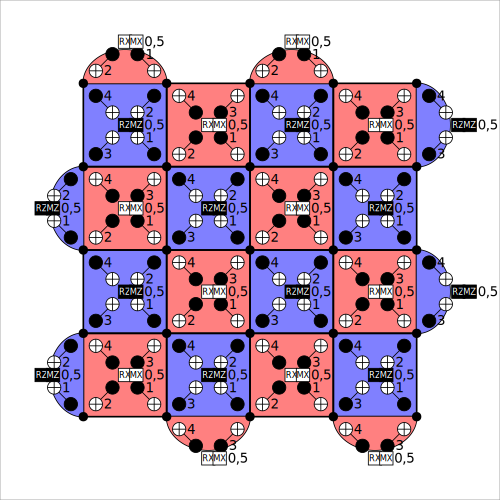

In [8]:
gen.svg(
    [make_surface_code_idle_chunk(make_surface_code(5)).circuit], 
    background=make_surface_code(5).patch,
    show_coords=False,
)

In [9]:
def make_surface_code_init_chunk(code: gen.StabilizerCode, init_basis: str) -> gen.Chunk:
    assert init_basis == "X" or init_basis == "Z", f"{init_basis=}"
    builder = gen.ChunkBuilder(allowed_qubits=code.used_set)

    # Init all data qubits in the specified basis.
    builder.append(f"R{init_basis}", code.data_set)

    # Annotate the expected flows.
    # - Stabilizers and observables matching the init basis are initialized by the resets.
    # - Stabilizers and observables not matching the init basis are explicitly discarded.
    #     (otherwise an error would occur when they are missing later during compilation.)
    for tile in code.tiles:
        if tile.basis == init_basis:
            builder.add_flow(end=tile)
        else:
            builder.add_discarded_flow_output(tile)
    for obs in code.flat_logicals:
        if all(b == init_basis for b in obs.values()):
            builder.add_flow(end=obs)
        else:
            builder.add_discarded_flow_output(obs)

    return builder.finish_chunk(wants_to_merge_with_next=True)

In [10]:
# Test and show

make_surface_code_init_chunk(make_surface_code(4), init_basis='X').verify()
make_surface_code_init_chunk(make_surface_code(4), init_basis='Z').verify()
make_surface_code_init_chunk(make_surface_code(5), init_basis='Z').verify()

make_surface_code_init_chunk(make_surface_code(5), init_basis='Z').to_html_viewer()

'\n<!DOCTYPE html>\n<html>\n<head>\n  <meta charset="UTF-8" />\n</head>\n<body>\n    <div id="circuit-viewer-container" tabindex=0>\n        <div id="step">Loading...</div>\n        <button id="btnPrev">Previous Layer (hotkey: q)</button>\n        <button id="btnNext">Next Layer (hotkey: e)</button>\n        <a id="crumble-link" href="https://algassert.com/crumble#circuit=Q%280,0%29_0;Q%280,1%29_1;Q%280,2%29_2;Q%280,3%29_3;Q%280,4%29_4;Q%281,0%29_5;Q%281,1%29_6;Q%281,2%29_7;Q%281,3%29_8;Q%281,4%29_9;Q%282,0%29_10;Q%282,1%29_11;Q%282,2%29_12;Q%282,3%29_13;Q%282,4%29_14;Q%283,0%29_15;Q%283,1%29_16;Q%283,2%29_17;Q%283,3%29_18;Q%283,4%29_19;Q%284,0%29_20;Q%284,1%29_21;Q%284,2%29_22;Q%284,3%29_23;Q%284,4%29_24;Q%28-0.5,1.5%29_25;Q%28-0.5,3.5%29_26;Q%280.5,-0.5%29_27;Q%280.5,0.5%29_28;Q%280.5,1.5%29_29;Q%280.5,2.5%29_30;Q%280.5,3.5%29_31;Q%281.5,0.5%29_32;Q%281.5,1.5%29_33;Q%281.5,2.5%29_34;Q%281.5,3.5%29_35;Q%281.5,4.5%29_36;Q%282.5,-0.5%29_37;Q%282.5,0.5%29_38;Q%282.5,1.5%29_39;Q%282.5,2.5%29_40;Q%282.5,3.5%29_41;Q%283.5,0.5%29_42;Q%283.5,1.5%29_43;Q%283.5,2.5%29_44;Q%283.5,3.5%29_45;Q%283.5,4.5%29_46;Q%284.5,0.5%29_47;Q%284.5,2.5%29_48;POLYGON%280,0,1,0.25%29_1_2;POLYGON%280,0,1,0.25%29_3_4;POLYGON%280,0,1,0.25%29_0_5_6_1;POLYGON%280,0,1,0.25%29_2_7_8_3;POLYGON%280,0,1,0.25%29_6_11_12_7;POLYGON%280,0,1,0.25%29_8_13_14_9;POLYGON%280,0,1,0.25%29_10_15_16_11;POLYGON%280,0,1,0.25%29_12_17_18_13;POLYGON%280,0,1,0.25%29_16_21_22_17;POLYGON%280,0,1,0.25%29_18_23_24_19;POLYGON%280,0,1,0.25%29_20_21;POLYGON%280,0,1,0.25%29_22_23;TICK;R_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24;TICK;MPP_Z0*Z1*Z5*Z6_Z2*Z3*Z7*Z8_Z10*Z11*Z15*Z16_Z12*Z13*Z17*Z18_Z20*Z21_Z22*Z23;TICK;MPP_Z1*Z2_Z3*Z4_Z6*Z7*Z11*Z12_Z8*Z9*Z13*Z14_Z16*Z17*Z21*Z22_Z18*Z19*Z23*Z24;DT%280.5,0.5,0%29_rec%5B-12%5D;DT%280.5,2.5,0%29_rec%5B-11%5D;DT%282.5,0.5,0%29_rec%5B-10%5D;DT%282.5,2.5,0%29_rec%5B-9%5D;DT%284.25,0.5,0%29_rec%5B-8%5D;DT%284.25,2.5,0%29_rec%5B-7%5D;DT%28-0.25,1.5,0%29_rec%5B-6%5D;DT%28-0.25,3.5,0%29_rec%5B-5%5D;DT%281.5,1.5,0%29_rec%5B-4%5D;DT%281.5,3.5,0%29_rec%5B-3%5D;DT%283.5,1.5,0%29_rec%5B-2%5D;DT%283.5,3.5,0%29_rec%5B-1%5D;TICK;OBSERVABLE_INCLUDE%280%29_Z0_Z5_Z10_Z15_Z20">Open in Crumble</a>\n        <div id="viewer"\n         style="border: 1px solid black; margin-bottom: 50px; width: 100%; height: 90vh;\n         resize: both; overflow: auto" tabindex="1" autofocus\n         ><img style="max-width: 95%; max-height: 95%; display: none" id=layer0 src="data:image/svg+xml;base64,PHN2ZyB4bWxucz0naHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmcnIHZpZXdCb3g9Jy05Ni4wIC05Ni4wIDU3Ni4wIDU3Ni4wJyBpZD0nbGF5ZXIwJz4KPHBhdGggZD0iTSAwLjAsOTYuMCBhIDAuOCwxLjAgMCAwLDAgMC4wLDk2LjAgTCAwLjAsOTYuMCIgZmlsbD0iIzAwMDBmZjQwIiBzdHJva2U9Im5vbmUiIC8+CjxwYXRoIGQ9Ik0gMC4wLDI4OC4wIGEgMC44LDEuMCAwIDAsMCAwLjAsOTYuMCBMIDAuMCwyODguMCIgZmlsbD0iIzAwMDBmZjQwIiBzdHJva2U9Im5vbmUiIC8+CjxwYXRoIGQ9Ik0wLjAsOTYuMCBMIDAuMCwwLjAgTCA5Ni4wLDAuMCBMIDk2LjAsOTYuMCBMIDAuMCw5Ni4wIiBmaWxsPSIjMDAwMGZmNDAiIHN0cm9rZT0ibm9uZSIgLz4KPHBhdGggZD0iTTAuMCwyODguMCBMIDAuMCwxOTIuMCBMIDk2LjAsMTkyLjAgTCA5Ni4wLDI4OC4wIEwgMC4wLDI4OC4wIiBmaWxsPSIjMDAwMGZmNDAiIHN0cm9rZT0ibm9uZSIgLz4KPHBhdGggZD0iTTk2LjAsMTkyLjAgTCA5Ni4wLDk2LjAgTCAxOTIuMCw5Ni4wIEwgMTkyLjAsMTkyLjAgTCA5Ni4wLDE5Mi4wIiBmaWxsPSIjMDAwMGZmNDAiIHN0cm9rZT0ibm9uZSIgLz4KPHBhdGggZD0iTTk2LjAsMzg0LjAgTCA5Ni4wLDI4OC4wIEwgMTkyLjAsMjg4LjAgTCAxOTIuMCwzODQuMCBMIDk2LjAsMzg0LjAiIGZpbGw9IiMwMDAwZmY0MCIgc3Ryb2tlPSJub25lIiAvPgo8cGF0aCBkPSJNMTkyLjAsOTYuMCBMIDE5Mi4wLDAuMCBMIDI4OC4wLDAuMCBMIDI4OC4wLDk2LjAgTCAxOTIuMCw5Ni4wIiBmaWxsPSIjMDAwMGZmNDAiIHN0cm9rZT0ibm9uZSIgLz4KPHBhdGggZD0iTTE5Mi4wLDI4OC4wIEwgMTkyLjAsMTkyLjAgTCAyODguMCwxOTIuMCBMIDI4OC4wLDI4OC4wIEwgMTkyLjAsMjg4LjAiIGZpbGw9IiMwMDAwZmY0MCIgc3Ryb2tlPSJub25lIiAvPgo8cGF0aCBkPSJNMjg4LjAsMTkyLjAgTCAyODguMCw5Ni4wIEwgMzg0LjAsOTYuMCBMIDM4NC4wLDE5Mi4wIEwgMjg4LjAsMTkyLjAiIGZpbGw9IiMwMDAwZmY0MCIgc3Ryb2tlPSJub25lIiAvPgo8cGF0aCBkPSJNMjg4LjAsMzg0LjAgTCAyODguMCwyODguMCBMIDM4NC4wLDI4OC4wIEwgMzg0LjAsMzg0LjAgTCAyODguMCwzODQuMCIgZmlsbD0iIzAwMDBmZjQwIiBzd

# Step 4: assemble chunks into a complete circuit

In [11]:
def make_surface_code_memory_circuit(code: gen.StabilizerCode, rounds: int) -> stim.Circuit:
    compiler = gen.ChunkCompiler()

    transversal_init = make_surface_code_init_chunk(code, "X")
    idle = make_surface_code_idle_chunk(code)
    transversal_measure = transversal_init.time_reversed()
    
    compiler.append(transversal_init)
    compiler.append(idle)
    compiler.append(idle)
    compiler.append(idle)
    compiler.append(transversal_measure)

    return compiler.finish_circuit()

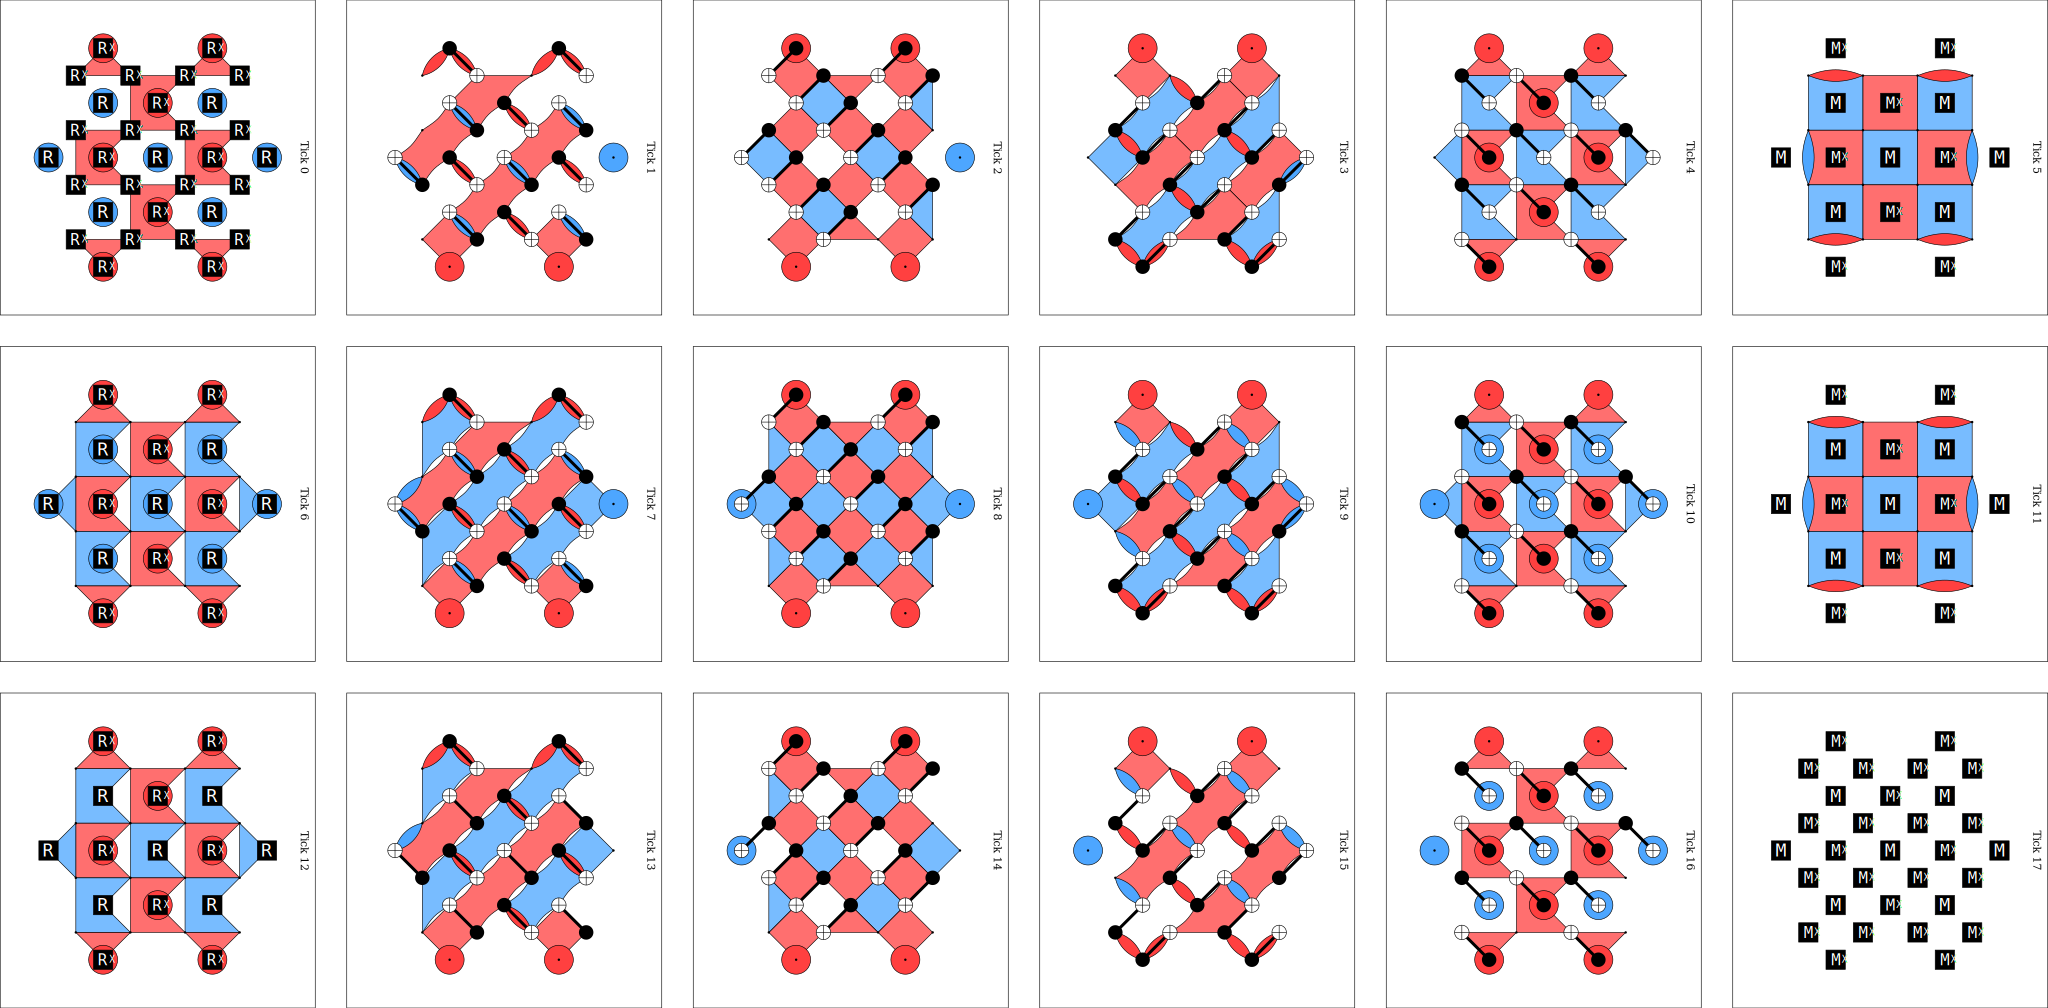

In [12]:
code = make_surface_code(4)
circuit = make_surface_code_memory_circuit(code, rounds=3)
circuit.diagram('detslice-with-ops-svg', rows=3)

# Step 5: transpile to CZ gates and add noise

In [13]:
code = make_surface_code(4)
cx_circuit = make_surface_code_memory_circuit(code, rounds=3)
cz_circuit = gen.transpile_to_z_basis_interaction_circuit(cx_circuit)

noise_model = gen.NoiseModel.si1000(1e-3)
noisy_circuit = noise_model.noisy_circuit(cz_circuit)
actual_distance = len(noisy_circuit.shortest_graphlike_error())
assert actual_distance == 4

gen.stim_circuit_html_viewer(noisy_circuit, patch=code)

'\n<!DOCTYPE html>\n<html>\n<head>\n  <meta charset="UTF-8" />\n</head>\n<body>\n    <div id="circuit-viewer-container" tabindex=0>\n        <div id="step">Loading...</div>\n        <button id="btnPrev">Previous Layer (hotkey: q)</button>\n        <button id="btnNext">Next Layer (hotkey: e)</button>\n        <a id="crumble-link" href="https://algassert.com/crumble#circuit=Q%280,0%29_0;Q%280,1%29_1;Q%280,2%29_2;Q%280,3%29_3;Q%281,0%29_4;Q%281,1%29_5;Q%281,2%29_6;Q%281,3%29_7;Q%282,0%29_8;Q%282,1%29_9;Q%282,2%29_10;Q%282,3%29_11;Q%283,0%29_12;Q%283,1%29_13;Q%283,2%29_14;Q%283,3%29_15;Q%28-0.5,1.5%29_16;Q%280.5,-0.5%29_17;Q%280.5,0.5%29_18;Q%280.5,1.5%29_19;Q%280.5,2.5%29_20;Q%280.5,3.5%29_21;Q%281.5,0.5%29_22;Q%281.5,1.5%29_23;Q%281.5,2.5%29_24;Q%282.5,-0.5%29_25;Q%282.5,0.5%29_26;Q%282.5,1.5%29_27;Q%282.5,2.5%29_28;Q%282.5,3.5%29_29;Q%283.5,1.5%29_30;POLYGON%280,0,1,0.25%29_1_2;POLYGON%281,0,0,0.25%29_4_0;POLYGON%280,0,1,0.25%29_0_4_5_1;POLYGON%281,0,0,0.25%29_1_5_6_2;POLYGON%280,0,1,0.25%29_2_6_7_3;POLYGON%281,0,0,0.25%29_3_7;POLYGON%281,0,0,0.25%29_4_8_9_5;POLYGON%280,0,1,0.25%29_5_9_10_6;POLYGON%281,0,0,0.25%29_6_10_11_7;POLYGON%281,0,0,0.25%29_12_8;POLYGON%280,0,1,0.25%29_8_12_13_9;POLYGON%281,0,0,0.25%29_9_13_14_10;POLYGON%280,0,1,0.25%29_10_14_15_11;POLYGON%281,0,0,0.25%29_11_15;POLYGON%280,0,1,0.25%29_13_14;TICK;R_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_17_19_21_22_24_25_27_29_16_18_20_23_26_28_30;X_ERROR%280.002%29_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_17_19_21_22_24_25_27_29_16_18_20_23_26_28_30;TICK;H_1_2_3_5_7_10_13_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30;DEPOLARIZE1%280.0001%29_1_2_3_5_7_10_13_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_0_4_6_8_9_11_12_14;TICK;CZ_2_16_4_17_5_18_6_19_7_20_9_22_10_23_11_24_12_25_13_26_14_27_15_28;DEPOLARIZE2%280.001%29_2_16_4_17_5_18_6_19_7_20_9_22_10_23_11_24_12_25_13_26_14_27_15_28;DEPOLARIZE1%280.0001%29_0_1_3_8_21_29_30;TICK;H_2_4_5_6_7_9_10_11_12_13_14_15;DEPOLARIZE1%280.0001%29_2_4_5_6_7_9_10_11_12_13_14_15_0_1_3_8_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30;TICK;CZ_0_17_1_16_2_19_4_18_5_22_6_20_7_24_8_25_9_23_10_27_12_26_14_28;DEPOLARIZE2%280.001%29_0_17_1_16_2_19_4_18_5_22_6_20_7_24_8_25_9_23_10_27_12_26_14_28;DEPOLARIZE1%280.0001%29_3_11_13_15_21_29_30;TICK;CZ_1_18_3_20_5_19_6_23_7_21_8_22_9_26_10_24_11_28_13_27_14_30_15_29;DEPOLARIZE2%280.001%29_1_18_3_20_5_19_6_23_7_21_8_22_9_26_10_24_11_28_13_27_14_30_15_29;DEPOLARIZE1%280.0001%29_0_2_4_12_16_17_25;TICK;H_0_1_2_3_4_5_6_7_8_9_10_11_13_15_16;DEPOLARIZE1%280.0001%29_0_1_2_3_4_5_6_7_8_9_10_11_13_15_16_12_14_17_18_19_20_21_22_23_24_25_26_27_28_29_30;TICK;CZ_0_18_1_19_2_20_3_21_4_22_5_23_6_24_8_26_9_27_10_28_11_29_13_30;DEPOLARIZE2%280.001%29_0_18_1_19_2_20_3_21_4_22_5_23_6_24_8_26_9_27_10_28_11_29_13_30;DEPOLARIZE1%280.0001%29_7_12_14_15_16_17_25;TICK;H_1_3_17_18_19_20_21_22_23_24_25_26_27_28_29_30;DEPOLARIZE1%280.0001%29_1_3_17_18_19_20_21_22_23_24_25_26_27_28_29_30_0_2_4_5_6_7_8_9_10_11_12_13_14_15_16;TICK;M%280.005%29_17_19_21_22_24_25_27_29_16_18_20_23_26_28_30;DT%280.5,-0.5,0%29_rec%5B-15%5D;DT%280.5,1.5,0%29_rec%5B-14%5D;DT%280.5,3.5,0%29_rec%5B-13%5D;DT%281.5,0.5,0%29_rec%5B-12%5D;DT%281.5,2.5,0%29_rec%5B-11%5D;DT%282.5,-0.5,0%29_rec%5B-10%5D;DT%282.5,1.5,0%29_rec%5B-9%5D;DT%282.5,3.5,0%29_rec%5B-8%5D;DEPOLARIZE1%280.001%29_17_19_21_22_24_25_27_29_16_18_20_23_26_28_30;DEPOLARIZE1%280.0001%29_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15;DEPOLARIZE1%280.002%29_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15;TICK;R_17_19_21_22_24_25_27_29_16_18_20_23_26_28_30;X_ERROR%280.002%29_17_19_21_22_24_25_27_29_16_18_20_23_26_28_30;DEPOLARIZE1%280.0001%29_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15;DEPOLARIZE1%280.002%29_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15;TICK;H_12_14_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30;DEPOLARIZE1%280.0001%29_12_14_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_0_1_2_3_4_5_6_7_8_9_10_11_13_15;TICK;CZ_2_16_4_17_5_18_6_19_7_20_9_22_10_23_11_24_12_25_13_26_14_27_15_28;DEPOLARIZE2%280.001%29_2_16_4_17_5_18_6_19_7_20_9_22_